# Shallow fully connected networks on MNIST using Keras

This notebook will guide you through the use of the `keras` package to train a shallow network for handwritten digits classification. You are going to use the `mnist` dataset from LeCun et al. 1998

We will use Tensorflow 2 (TF 2) and the Keras API. If you need to install some packages, use `pip install ...`, e.g. `pip install sklearn` for SciKit Learn.

## Loading the packages

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
# First, import TF and get its version.
import tensorflow as tf
from tensorflow import keras

tf_version = tf.__version__

# Check if version >=2.0.0 is used
if not tf_version.startswith('2.'):
    print(
        'WARNING: TensorFlow >= 2.0.0 will be used in this course.\nYour version is {}'.format(tf_version) + '.\033[0m')
else:
    print('OK: TensorFlow >= 2.0.0' + '.\033[0m')

OK: TensorFlow >= 2.0.0.


## Loading the raw data
Keras provides easy access to different datasets including MNIST. First load the `mnist` dataset and normalize it to be in the range [0, 1]

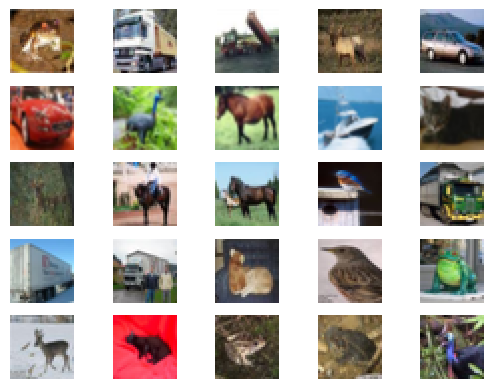

In [3]:
def show_imgs(X):
    plt.figure(1)
    k = 0
    for i in range(0, 5):
        for j in range(0, 5):
            plt.subplot2grid((5, 5), (i, j))
            plt.imshow(X[k], cmap='gray')
            k = k + 1
            plt.axis('off')
    plt.show()


(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

show_imgs(X_train)

In [4]:
print(f"Shape of X_train is: {X_train.shape} and X_test is: {X_test.shape}")
print(f"Shape of y_train is: {y_train.shape} and y_test is: {y_test.shape}")
print(f"Number of target values: {len(np.unique(y_train))}")

Shape of X_train is: (50000, 32, 32, 3) and X_test is: (10000, 32, 32, 3)
Shape of y_train is: (50000, 1) and y_test is: (10000, 1)
Number of target values: 10


In [5]:
# print(f"First 5 input values {X_train[:1,:,:]}")
print(f"First 5 target values {y_train[:1, ]}")

First 5 target values [[6]]


In [6]:
X_train = X_train.reshape(50000, 32 * 32 * 3)
X_test = X_test.reshape(10000, 32 * 32 * 3)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape, 'train samples')
print(X_test.shape, 'test samples')
print(X_train[:1])

(50000, 3072) train samples
(10000, 3072) test samples
[[0.23137255 0.24313726 0.24705882 ... 0.48235294 0.36078432 0.28235295]]


The target values of the network are supposed to be 1-hot targets. Now the `y_train` is an array with scalar values as in `[5 0 4 1 ...]` and it should be a 1-hot array `Y_train` as in : 

`[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]...]`
 
Note the change of capital letter in the `Y_train` to denote, per convention, an array with multiple dimensions.

In [7]:
n_classes = 10
Y_train = keras.utils.to_categorical(y_train, n_classes)
Y_test = keras.utils.to_categorical(y_test, n_classes)
print(Y_train[:10])

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


# One-layer network and weight visualisation
## Define the network

In [8]:
n_epochs = 5  # number of epochs
batch_size = 128  # batch size
input_dimension = X_train.shape[1]  # dimension of input sample - 784 for MNIST

model = keras.Sequential()
model.add(keras.layers.InputLayer(shape=(input_dimension,)))
model.add(keras.layers.Dense(200, activation='relu', kernel_regularizer=keras.regularizers.l2(0.05)))
model.add(keras.layers.Dense(n_classes, activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │       614,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 616,610 (2.35 MB)

 Trainable params: 616,610 (2.35 MB)

 Non-trainable params: 0 (0.00 B)

## Compile and train the network
In Keras, we call the methods `compile()` and `fit()`. For the compile phase, we need to specify the **loss** function which should be set in the case of multi-class classification to `categorical_crossentropy`. We also need to specify the optimizer strategy. In this case the `rmsprop` or `adam` can be used.

In [9]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
log = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test))

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2497 - loss: 5.9047 - val_accuracy: 0.2975 - val_loss: 2.0458
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2935 - loss: 2.0791 - val_accuracy: 0.3282 - val_loss: 1.9967
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3067 - loss: 2.0195 - val_accuracy: 0.3034 - val_loss: 2.0317
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3084 - loss: 2.0226 - val_accuracy: 0.3362 - val_loss: 1.9858
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3076 - loss: 2.0131 - val_accuracy: 0.2866 - val_loss: 2.0132


## Evaluate the network

We can do this at three levels: (1) plot of the loss during the training phase, (2) overall accuracy evaluation on test set and (3) per class evaluation with confusion matrix on test set.

### Loss evolution during training
This can be done first looking at the history of the training (output of the `fit()` function).

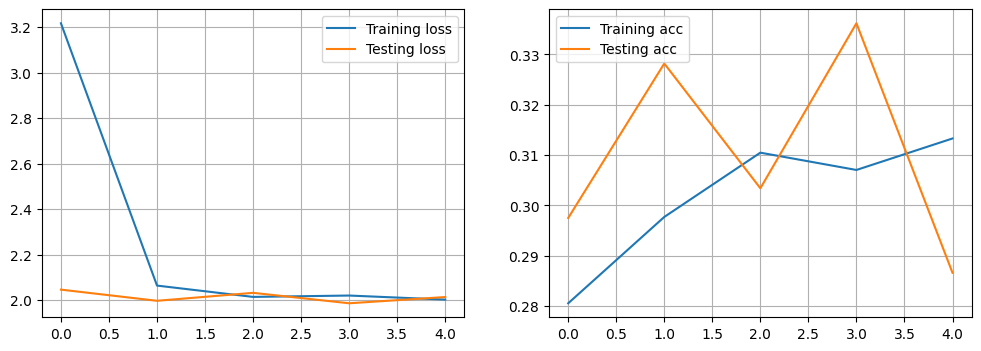

In [10]:
f = plt.figure(figsize=(12, 4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(log.history['loss'], label='Training loss')
ax1.plot(log.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(log.history['accuracy'], label='Training acc')
ax2.plot(log.history['val_accuracy'], label='Testing acc')
ax2.legend()
ax2.grid()

### Model evaluation
We can compute the overall performance on test set calling the `evaluate()` function on the model. The function returns the loss and the metrics used to compile the models.

In [11]:
loss_test, metric_test = model.evaluate(X_test, Y_test)
print('Test loss:', loss_test)
print('Test accuracy:', metric_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - accuracy: 0.2863 - loss: 2.0199
Test loss: 2.015950918197632
Test accuracy: 0.2865999937057495


### Confusion matrix
We can call the `predict()` function to get the predicted classes. The output of this function is an array with the predicted class probabilities, from which we need to take the argmax for each row to get the class label as in `[5 0 4 1 ...]`. The output array of ground truth `y_test` and the predicted classes can then be fed to the `confusion_matrix()` function of [sklearn metrics package](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix).

In [12]:
pred = model.predict(X_test, verbose=1)
y_pred = pred.argmax(axis=-1)
cm = confusion_matrix(y_test, y_pred)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step


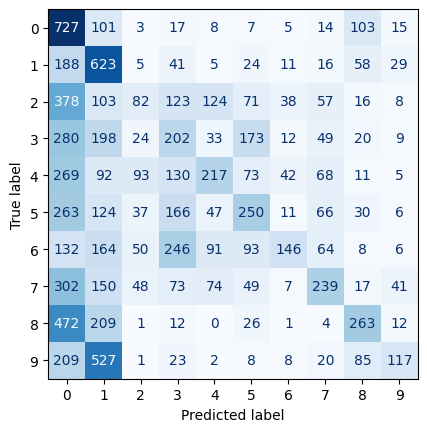

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(colorbar=False, cmap='Blues')
plt.show()

### Plot the weights
The weights connected to a given neuron, when using a one-layer network, have the same shape as the input. They can therefore be plot. To do so we need to re-scale the weight values into 0-255 pixel values.

(3072, 200)
(200,)
(200, 10)
(10,)


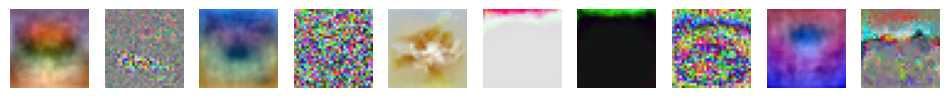

In [14]:
weights = model.get_weights()
for w in weights:
    print(w.shape)
w1 = weights[0]
f = plt.figure(figsize=(12, 12))
for i in range(10):
    ax = f.add_subplot(1, 10, 1 + i)
    im = w1[:, i]  # get the weights landing to neuron i
    im = im.reshape(32, 32, 3)  # reshape the vector of weights into 28x28 image
    # now put back the pixel values to 0-256 doing a min-max norm and multiplying by 256
    min = np.min(im)
    max = np.max(im)
    im = np.round((im - min) / (max - min) * 255).astype(int)
    ax.axis('off')
    ax.imshow(im)